In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from scipy.stats import zscore
from scipy import stats
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint, LinearConstraint

from matplotlib import pyplot as plt
plt.style.use('./hockenberry.mplstyle')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

###The following is used to create some sensible results folders according to the year/month
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Defining constants

In [3]:
sparse_data = True
save_figs = True
if sparse_data and save_figs:
    figs_dir += '/sparse_data'
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

In [4]:
metric = 'CAI'
# metric = 'tAI'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'

if save_figs:
    figs_dir += '/{}'.format(metric)
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

# Import data

In [5]:
full_df = pd.read_csv('../Data/ecoli_info/current_ecoli_master_table.tsv', sep='\t', index_col=0)
full_df.head()

,gene,start_loc,stop_loc,strand,cds_seq,us_seq,cds_len,well_behaved,GC_percent_cds,roc_semppr_mean,iCUB,CAI,tAI,stAIcalc
locus_tag,,,,,,,,,,,,,,
b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,66,True,0.515152,1.244106,0.706194,0.617266,0.262286,0.258417
b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,2463,True,0.530654,1.034078,0.123189,0.353246,0.230564,0.216862
b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,933,True,0.562701,0.994168,0.120430,0.357812,0.216292,0.210420
b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,1287,True,0.528361,1.176750,0.193835,0.394675,0.231407,0.209784
b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,297,True,0.538721,0.837528,0.251085,0.374371,0.197715,0.208944


In [6]:
if sparse_data:
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata_SPARSE.tsv', sep='\t', index_col=0)
else:
    meta_df = pd.read_csv('../Data/processed_data/processed_metadata.tsv', sep='\t', index_col=0)
print(meta_df.shape)
meta_df.head()

(30, 27)


,Sample ID,Study,Project ID,Condition ID,Strain Description,Strain,Base Media,Carbon Source (g/L),Nitrogen Source (g/L),Electron Acceptor,...,Additional Details,DOI,GEO,Simple_sample_id,Temperature (C),pH,Growth Rate (1/hr),Alignment,Replicate #,Doubling_time
59,omics__bw_glc__1,Omics,omics,bw_glc,Escherichia coli BW25113,BW25113,M9,glucose(5),NH4Cl(1),O2,...,NaN,doi.org/10.1038/ncomms13091,GSE59759,omics__bw_glc,37,7.0,0.6075,97.875,2,1.140983
83,cra_crp__wt_fru__1,Cra/Crp,cra_crp,wt_fru,Escherichia coli K-12 MG1655,MG1655,M9,fructose(2),NH4Cl(1),O2,...,NaN,doi.org/10.1093/nar/gky069,GSE65643,cra_crp__wt_fru,37,7.0,0.5300,97.680,2,1.307825
97,rpoB__rpoBE546V_lb__1,RpoB Knock-in,rpoB,rpoBE546V_lb,Escherichia coli K-12 MG1655 rpoBE546V,MG1655,LB,NaN,NaN,O2,...,NaN,doi.org/10.1016/j.cels.2016.04.003,GSE59377,rpoB__rpoBE546V_lb,37,7.0,1.3400,98.575,2,0.517274
131,42c__wt_42c__1,42C Evolution,42c,wt_42c,Escherichia coli K-12 MG1655,MG1655,M9,glucose(4),NH4Cl(1),O2,...,NaN,doi.org/10.1093/molbev/msu209,GSE132442,42c__wt_42c,42,7.0,0.8200,98.370,1,0.845301
132,42c__42c_ale1__1,42C Evolution,42c,42c_ale1,Escherichia coli 42C.1.124.1,MG1655,M9,glucose(4),NH4Cl(1),O2,...,42C A1 F124 I1,doi.org/10.1093/molbev/msu209,GSE132442,42c__42c_ale1,42,7.0,0.9500,98.400,1,0.729629


In [7]:
if sparse_data:
    exp_df = pd.read_csv('../Data/processed_data/processed_expression_SPARSE.tsv', sep='\t', index_col=0)
else:
    exp_df = pd.read_csv('../Data/processed_data/processed_expression.tsv', sep='\t', index_col=0)
print(exp_df.shape)
exp_df.head()

(3923, 30)


,omics__bw_glc,cra_crp__wt_fru,rpoB__rpoBE546V_lb,42c__wt_42c,42c__42c_ale1,42c__42c_ale10,ssw__wt_ac,ssw__wt_glc,ssw__wt_glyc,ssw__wt_xyl,...,ica__bw_delpurR_cytd,ytf__delyiaJ,ytf__delybiH,fps__fps_serB_ale4,pal__lyx_ale2_f6,pal__5drib_ale10,pal__tartr_ale26_f10,pal__tartr_ale28,efeU__menFentC_ale29,efeU__menFentCubiC_ale38
log-TPM,,,,,,,,,,,,,,,,,,,,,
b0002,10.213469,11.198040,8.163975,11.499706,9.341696,10.936601,7.049774,10.445776,7.678018,12.116177,...,11.355471,10.108921,10.997329,9.637229,9.627287,8.433396,7.907166,8.134838,10.273946,11.524586
b0003,9.643784,10.182029,8.127386,10.770397,8.807134,10.873113,7.265206,9.787075,8.384440,11.883905,...,10.689982,9.369616,10.346011,9.083919,9.250534,8.298816,8.026256,7.992993,10.138576,10.694248
b0004,9.876957,10.037740,8.065428,10.785005,8.996823,10.356236,7.371951,9.916621,8.745754,11.992770,...,10.989716,9.355340,10.279033,9.234281,9.203814,8.550062,8.090676,8.173352,10.454710,10.977106
b0005,5.909349,6.058802,3.848184,5.455772,4.749646,6.105699,3.707233,4.968974,5.925175,7.244506,...,6.164810,4.639188,5.451973,6.195112,4.807384,4.677902,3.684667,4.050593,5.842332,5.841291
b0006,6.876792,6.555468,6.963816,7.316602,6.658317,6.848067,6.595414,6.996502,6.186970,5.285927,...,7.199466,6.713470,6.748590,7.503775,6.398236,6.546094,6.635715,6.675508,8.346839,8.081482


In [8]:
if sparse_data:
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary_SPARSE.tsv', sep='\t', index_col=0)
else:
    exp_summary_df = pd.read_csv('../Data/processed_data/processed_expression_summary.tsv', sep='\t', index_col=0)


print(exp_summary_df.shape)
exp_summary_df.head()

(3923, 13)


,count,mean,std,min,25_percentile,50_percentile,75_percentile,max,cv,noise,lin_slope,lin_r,spearmans_rho
log-TPM,,,,,,,,,,,,,
b0002,30.0,9.793315,1.444897,7.049774,8.396229,10.072792,10.968085,12.116177,0.147539,0.021768,0.044448,0.220242,0.281010
b0003,30.0,9.430157,1.206869,7.265206,8.320222,9.506700,10.306421,11.883905,0.127980,0.016379,0.055293,0.228843,0.321949
b0004,30.0,9.512561,1.185379,7.371951,8.598985,9.426478,10.336935,11.992770,0.124612,0.015528,0.053242,0.216430,0.287685
b0005,30.0,5.293082,1.020252,3.161854,4.681027,5.412823,6.025395,7.244506,0.192752,0.037153,0.077310,0.270489,0.348871
b0006,30.0,6.814419,0.593300,5.285927,6.554015,6.694489,7.086320,8.346839,0.087065,0.007580,0.141197,0.287281,0.355323


In [9]:
full_df = full_df.merge(exp_summary_df, how='inner', left_index=True, right_index=True)

# Find the individual conditions whose gene expression is most (and least) correlated with CUB

In [10]:
temp_df = exp_df.loc[full_df.index]
corrs = []
growth = []
min_r = 1
min_col = (np.nan, '')
max_r = 0
max_col = (np.nan, '')
for i, col in enumerate(temp_df.columns):
    r, p = stats.pearsonr(full_df[metric], temp_df[col])
    r2 = r**2
    corrs.append(r2)
    assert meta_df[meta_df['Simple_sample_id']==col].shape[0]==1
    growth.append(meta_df[meta_df['Simple_sample_id']==col].iloc[0]['Growth Rate (1/hr)'])
    if r2 > max_r:
        max_r = r2
        max_col = (i, col)
    if r2 < min_r:
        min_r = r2
        min_col = (i, col)
print(max_col, max_r)
print(min_col, min_r)

(2, 'rpoB__rpoBE546V_lb') 0.27372404621293445
(17, 'ica__cytd_rib') 0.1532956834039022


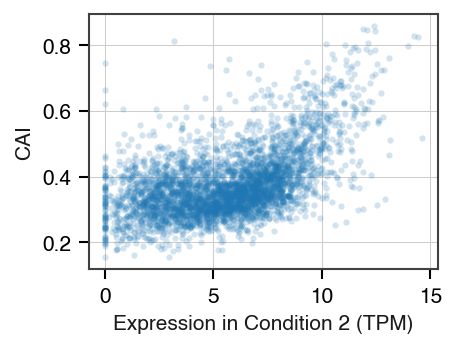

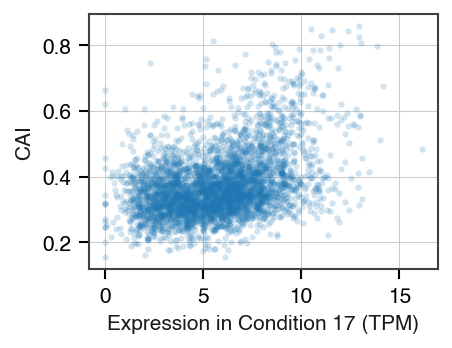

In [11]:
assert all(temp_df.index == full_df.index)
fig, ax = plt.subplots()
ax.plot(temp_df[max_col[1]], full_df[metric], marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Expression in Condition {} (TPM)'.format(max_col[0]))
ax.set_ylabel(metric)
if save_figs:
    plt.savefig(figs_dir+'/{}_vs_Cond{}.pdf'.format(metric, max_col[0]), bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(temp_df[min_col[1]], full_df[metric], marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Expression in Condition {} (TPM)'.format(min_col[0]))
ax.set_ylabel(metric)
if save_figs:
    plt.savefig(figs_dir+'/{}_vs_Cond{}.pdf'.format(metric, min_col[0]), bbox_inches='tight')

SpearmanrResult(correlation=0.47880743426776784, pvalue=0.007433986962636512)
(0.47994123960371976, 0.007274753958909519)


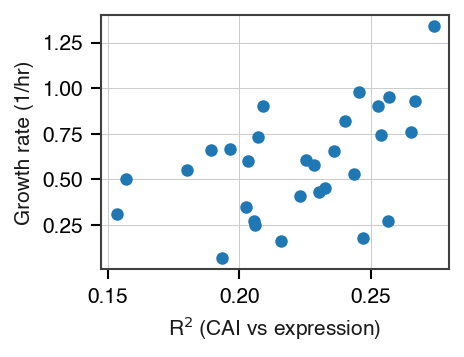

In [12]:
fig, ax = plt.subplots()
ax.plot(corrs, growth, marker='o', linestyle='')
ax.set_xlabel('R$^2$ ({} vs expression)'.format(metric))
ax.set_ylabel('Growth rate (1/hr)')
print(stats.spearmanr(corrs, growth))
print(stats.pearsonr(corrs, growth))
if save_figs:
    plt.savefig(figs_dir+'/growth_vs_cond_corrs.pdf', bbox_inches='tight')

# Determine which expression-based summary statistics are *most* correlated with CUB metrics

In [13]:
print(full_df.columns)

Index(['gene', 'start_loc', 'stop_loc', 'strand', 'cds_seq', 'us_seq',
       'cds_len', 'well_behaved', 'GC_percent_cds', 'roc_semppr_mean', 'iCUB',
       'CAI', 'tAI', 'stAIcalc', 'count', 'mean', 'std', 'min',
       '25_percentile', '50_percentile', '75_percentile', 'max', 'cv', 'noise',
       'lin_slope', 'lin_r', 'spearmans_rho'],
      dtype='object')


In [14]:
gene_metrics = ['cds_len', 'GC_percent_cds', 'roc_semppr_mean', 'iCUB',\
               'CAI', 'tAI', 'stAIcalc']

sstats = ['mean', '50_percentile', 'max', 'min']

corrs_dict = {}
for temp_metric in gene_metrics:
    print('########################### {}'.format(temp_metric))
    cub_corrs = []
    for sstat in sstats:
        r, p = stats.pearsonr(full_df[temp_metric], full_df[sstat])
        r2 = r**2
        print(sstat, r2, p)
        cub_corrs.append(r2)
    corrs_dict[temp_metric] = cub_corrs
    print()

########################### cds_len
mean 0.00042764023404804274 0.19902055504999555
50_percentile 0.0007836380442538675 0.08207705976286264
max 0.003116686118362668 0.0005211932025441868
min 0.00226940562475784 0.003075869236976327

########################### GC_percent_cds
mean 0.01393448914247194 1.8896820324489504e-13
50_percentile 0.012392549735515441 4.069985986984927e-12
max 0.008272531417382468 1.5136425132939323e-08
min 0.025636052467501863 1.409388870101948e-23

########################### roc_semppr_mean
mean 0.2470148581377338 6.23258761696549e-240
50_percentile 0.2338011411780434 2.3800169827564083e-225
max 0.21717156263324422 2.3768771022102265e-207
min 0.21363871913905555 1.415125568650018e-203

########################### iCUB
mean 0.11514872753954775 1.3080715309133407e-104
50_percentile 0.1152285946853666 1.0987064278463365e-104
max 0.12951428284730357 2.4111069117729255e-118
min 0.05334896231484057 6.69115666409533e-48

########################### CAI
mean 0.26425538

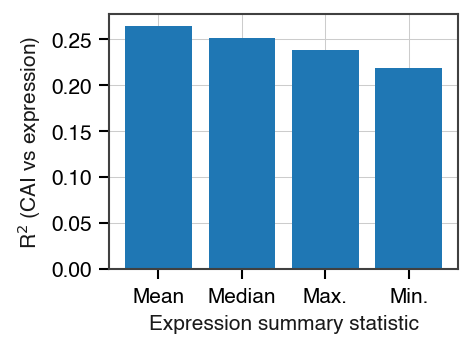

In [15]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(corrs_dict[metric])), corrs_dict[metric])
ax.set_ylabel('R$^2$ ({} vs expression)'.format(metric))
ax.set_xticks(np.arange(len(corrs_dict[metric])))
ax.set_xticklabels(['Mean', 'Median', 'Max.', 'Min.'], rotation=0)
ax.set_xlabel('Expression summary statistic')
if save_figs:
    plt.savefig(figs_dir+'/{}_summary_stats_corr.pdf'.format(metric), bbox_inches='tight')

## Hair-brained scheme to optimize weights

In [16]:
# def custom_corr_fxn(weights, exp_df, full_df):
#     all_vals = []
#     for gene in full_df.index:
#         all_vals.append(np.average(exp_df.loc[gene], weights=weights))
#     rho, p = stats.spearmanr(all_vals, full_df['CAI'])
#     print('here {}'.format(rho))
#     return (1-rho)

In [17]:
# x0 = np.random.random(size=len(exp_df.columns))
# x0 = x0 / np.sum(x0)
# print(np.sum(x0))
# constraints = [{'type': 'eq', 'fun': lambda x: 1 - sum(x)},
#                {'type': 'ineq', 'fun': lambda x: x}]

# res = minimize(custom_corr_fxn, x0, args=(exp_df, full_df), method='SLSQP', constraints=constraints,
#                options={'maxiter': 20, 'disp': True, 'eps':1e-1})

In [18]:
# bounds = [(0,1) for i in exp_df.columns]
# def constr_f(x):
#     return np.sum(x)
# nlc = NonlinearConstraint(constr_f, 1.0, 1.0)

# res = differential_evolution(custom_corr_fxn,\
#                              bounds=np.array(bounds),\
#                              args=(exp_df, full_df),\
#                              constraints=[nlc])

In [19]:
# fig, ax = plt.subplots()
# ax.scatter(res.x, meta_df['Growth Rate (1/hr)'])

# Regression analysis to assess predictors of CUB

In [20]:
full_df.columns

Index(['gene', 'start_loc', 'stop_loc', 'strand', 'cds_seq', 'us_seq',
       'cds_len', 'well_behaved', 'GC_percent_cds', 'roc_semppr_mean', 'iCUB',
       'CAI', 'tAI', 'stAIcalc', 'count', 'mean', 'std', 'min',
       '25_percentile', '50_percentile', '75_percentile', 'max', 'cv', 'noise',
       'lin_slope', 'lin_r', 'spearmans_rho'],
      dtype='object')

In [21]:
model_correlations = []

In [22]:
###Model 1, average expression
model1_params = []
fitted = smf.ols('zscore({}) ~ zscore(mean)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model_correlations.append(fitted.rsquared_adj)
model1_params = list(zip(params, cis.values))
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            zscore(CAI)   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     1385.
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          2.40e-259
Time:                        17:22:55   Log-Likelihood:                -4883.6
No. Observations:                3859   AIC:                             9771.
Df Residuals:                    3857   BIC:                             9784.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.985e-16      0.014   4.33e-14      1.000      -0.027       0.027
zscore(mean)     0.5141      0.014     37.220      0.000       0.487       0.541
==============================================================================
Omnibus:                      451.334   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.516
Skew:                           0.837   Prob(JB):                    2.82e-153
Kurtosis:                       4.252   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
###Model 2, growth correlation
model2_params = []
fitted = smf.ols('zscore({}) ~ zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model2_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)


fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            zscore(CAI)   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     351.4
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           4.24e-75
Time:                        17:22:55   Log-Likelihood:                -5307.5
No. Observations:                3859   AIC:                         1.062e+04
Df Residuals:                    3857   BIC:                         1.063e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.985e-16      0.015   3.88e-14      1.000      -0.030       0.030
zscore(lin_r)     0.2889      0.015     18.745      0.000       0.259       0.319
==============================================================================
Omnibus:                      795.743   Durbin-Watson:                   1.548
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1745.819
Skew:                           1.180   Prob(JB):                         0.00
Kurtosis:                       5.300   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
###Model 3, all together
model3_params = []
fitted = smf.ols('zscore({}) ~ zscore(mean) + zscore(lin_r)'.format(metric), data=full_df).fit()
params = fitted.params
cis = fitted.conf_int(alpha=0.05, cols=None)
model3_params = list(zip(params, cis.values))
model_correlations.append(fitted.rsquared_adj)
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            zscore(CAI)   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     781.8
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          9.53e-286
Time:                        17:22:55   Log-Likelihood:                -4818.9
No. Observations:                3859   AIC:                             9644.
Df Residuals:                    3856   BIC:                             9663.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.985e-16      0.014   4.41e-14      1.000      -0.027       0.027
zscore(mean)      0.4703      0.014     33.334      0.000       0.443       0.498
zscore(lin_r)     0.1618      0.014     11.466      0.000       0.134       0.189
==============================================================================
Omnibus:                      437.089   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              681.191
Skew:                           0.814   Prob(JB):                    1.21e-148
Kurtosis:                       4.259   Cond. No.                         1.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

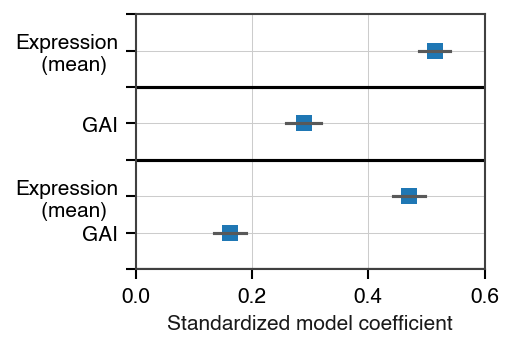

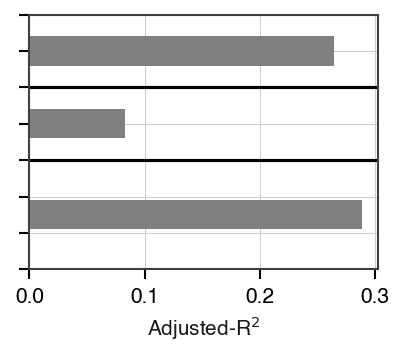

In [25]:
counter = 0
fig, ax = plt.subplots()
for model_params in [model1_params, model2_params, model3_params]:
    for i,ind_param in enumerate(model_params[1:]):
        plt.plot(ind_param[0], -i+counter, marker='s', markersize=8, color=color_cycle[0])
        plt.plot([ind_param[1][0], ind_param[1][1]], [-i+counter, -i+counter], marker='', color='0.35')
    ax.axhline(-i+counter-1, c='k')
    counter -= 2
ax.set_ylim(-6, 1)
ax.set_yticks(range(-6, 2))
labels_top_to_bottom = ['', 'Expression\n(mean)\t\t', '',\
                    'GAI', '',\
                    'Expression\n(mean)\t\t', 'GAI', '']
ax.set_yticklabels(labels_top_to_bottom[::-1])
ax.set_xlabel('Standardized model coefficient')
ax.set_xlim(0, 0.6)
if save_figs:
    plt.savefig(figs_dir+'/{}_model_comp_coefs.pdf'.format(metric), bbox_inches='tight')

fig, ax = plt.subplots()
ax.barh(0, model_correlations[0], 0.8, facecolor='0.5')
ax.barh(-2, model_correlations[1], 0.8, facecolor='0.5')
ax.barh(-4.5, model_correlations[2], 0.8, facecolor='0.5')
ax.axhline(-1, c='k')
ax.axhline(-3, c='k')
ax.set_ylim(-6, 1)
ax.set_yticks(range(-6, 2))
ax.set_yticklabels([''])
ax.set_xlabel('Adjusted-R$^2$');
if save_figs:
    plt.savefig(figs_dir+'/{}_model_comp_R2.pdf'.format(metric), bbox_inches='tight')

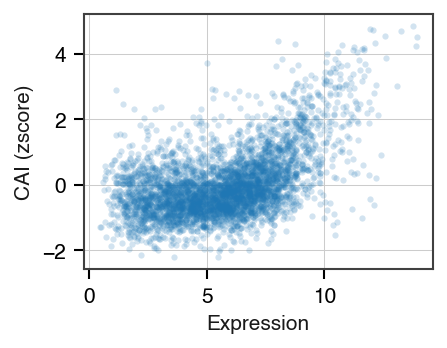

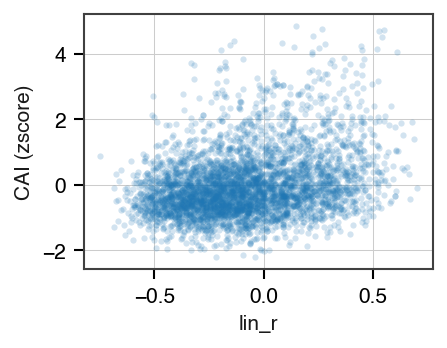

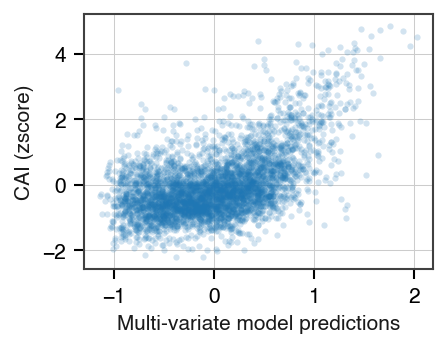

In [26]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], zscore(full_df[metric]), marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Expression')
ax.set_ylabel('{} (zscore)'.format(metric))

fig, ax = plt.subplots()
ax.plot(full_df['lin_r'], zscore(full_df[metric]), marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('lin_r')
ax.set_ylabel('{} (zscore)'.format(metric))

fig, ax = plt.subplots()
ax.plot(fitted.predict(), zscore(full_df[metric]), marker='.', linestyle='', alpha=0.2)
ax.set_xlabel('Multi-variate model predictions')
ax.set_ylabel('{} (zscore)'.format(metric))
if save_figs:
    plt.savefig(figs_dir+'/{}_best_additive.pdf'.format(metric), bbox_inches='tight')

**Ensure that results are consistent when using with value from the highest correlation condition rather than the mean**

In [27]:
temp_df = full_df.merge(exp_df, left_index=True, right_index=True, how='inner')

In [28]:
fitted = smf.ols('zscore({}) ~ zscore({}) + zscore(lin_r)'.format(metric, max_col[1]), data=temp_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            zscore(CAI)   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     804.8
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          8.24e-293
Time:                        17:23:20   Log-Likelihood:                -4802.6
No. Observations:                3859   AIC:                             9611.
Df Residuals:                    3856   BIC:                             9630.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   5.985e-16      0.014   4.42e-14      1.000      -0.027       0.027
zscore(rpoB__rpoBE546V_lb)     0.4798      0.014     33.959      0.000       0.452       0.507
zscore(lin_r)                  0.1505      0.014     10.653      0.000       0.123       0.178
==============================================================================
Omnibus:                      624.943   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1187.163
Skew:                           1.002   Prob(JB):                    1.63e-258
Kurtosis:                       4.836   Cond. No.                         1.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Visualizing an interaction effect

In [29]:
fitted = smf.ols('{} ~ mean * lin_r'.format(metric), data=full_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     588.5
Date:                Tue, 23 Mar 2021   Prob (F-statistic):          6.76e-315
Time:                        17:23:27   Log-Likelihood:                 4163.5
No. Observations:                3859   AIC:                            -8319.
Df Residuals:                    3855   BIC:                            -8294.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2569      0.004     67.522      0.000       0.249       0.264
mean           0.0210      0.001     35.482      0.000       0.020       0.022
lin_r         -0.0937      0.014     -6.823      0.000      -0.121      -0.067
mean:lin_r     0.0258      0.002     11.993      0.000       0.022       0.030
==============================================================================
Omnibus:                      438.841   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.282
Skew:                           0.803   Prob(JB):                    1.17e-153
Kurtosis:                       4.341   Cond. No.                         65.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

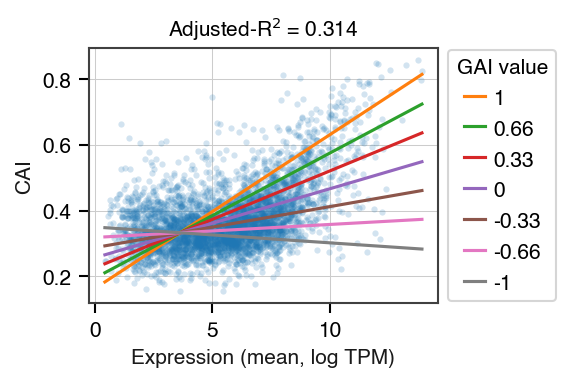

In [30]:
growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
#Plot the resulting data
fig, ax = plt.subplots()
x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*x_vals) +\
            (fitted.params[2]*i) +\
            (fitted.params[3]*x_vals*i), label=i)
ax.set_xlabel('Expression (mean, log TPM)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GAI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-R$^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_best_interaction.pdf'.format(metric), bbox_inches='tight')

# Polynomial fit

In [31]:
fitted = smf.ols('{} ~ np.power(mean, 2) + np.power(mean, 1) + lin_r'.format(metric), data=full_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     830.5
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:24:01   Log-Likelihood:                 4397.9
No. Observations:                3859   AIC:                            -8788.
Df Residuals:                    3855   BIC:                            -8763.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3960      0.006     65.553      0.000       0.384       0.408
np.power(mean, 2)     0.0046      0.000     25.698      0.000       0.004       0.005
np.power(mean, 1)    -0.0332      0.002    -15.572      0.000      -0.037      -0.029
lin_r                 0.0469      0.005      9.769      0.000       0.038       0.056
==============================================================================
Omnibus:                      292.908   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              608.677
Skew:                           0.502   Prob(JB):                    6.72e-133
Kurtosis:                       4.667   Cond. No.                         244.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

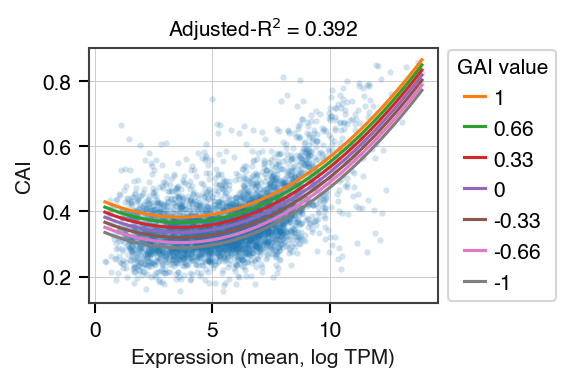

In [32]:
growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
#Plot the resulting data
fig, ax = plt.subplots()
x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*np.power(x_vals, 2)) +\
            (fitted.params[2]*np.power(x_vals, 1)) +\
            (fitted.params[3]*i), label=i)
ax.set_xlabel('Expression (mean, log TPM)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GAI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-R$^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_poly_multi.pdf'.format(metric), bbox_inches='tight')

In [33]:
fitted = smf.ols('{} ~ np.power(mean, 2) * lin_r + np.power(mean, 1) * lin_r'.format(metric), data=full_df).fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CAI   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     510.3
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:24:02   Log-Likelihood:                 4416.4
No. Observations:                3859   AIC:                            -8821.
Df Residuals:                    3853   BIC:                            -8783.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.3874      0.007     58.217      0.000       0.374       0.400
np.power(mean, 2)           0.0043      0.000     22.861      0.000       0.004       0.005
lin_r                       0.0691      0.025      2.741      0.006       0.020       0.119
np.power(mean, 2):lin_r     0.0025      0.001      3.810      0.000       0.001       0.004
np.power(mean, 1)          -0.0301      0.002    -13.233      0.000      -0.035      -0.026
np.power(mean, 1):lin_r    -0.0207      0.008     -2.475      0.013      -0.037      -0.004
==============================================================================
Omnibus:                      330.344   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.414
Skew:                           0.555   Prob(JB):                    7.27e-151
Kurtosis:                       4.752   Cond. No.                     1.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

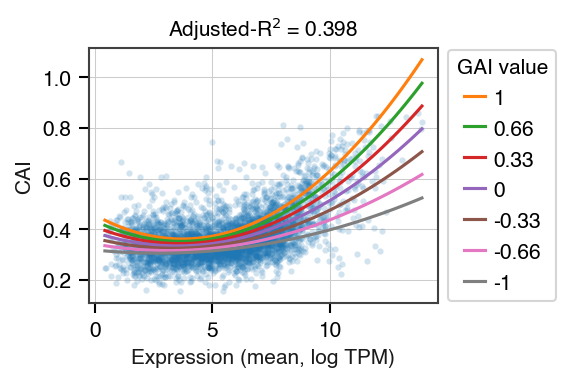

In [34]:
growth_corrs = [-1, -0.66, -0.33, 0, 0.33, 0.66, 1]
#Plot the resulting data
fig, ax = plt.subplots()
x_vals = np.linspace(full_df['mean'].min(), full_df['mean'].max(), 100)
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in growth_corrs[::-1]:
    ax.plot(x_vals, fitted.params[0] +\
            (fitted.params[1]*np.power(x_vals, 2)) +\
            (fitted.params[2]*i) +\
            (fitted.params[3]*np.power(x_vals, 2)*i) +\
            (fitted.params[4]*x_vals) +\
            (fitted.params[5]*x_vals*i), label=i)
ax.set_xlabel('Expression (mean, log TPM)')
ax.set_ylabel('{}'.format(metric))
leg = ax.legend(title='GAI value', bbox_to_anchor=(1, 1.035))
plt.setp(leg.get_title(), multialignment='center')
ax.set_title('Adjusted-R$^2$ = {:.3f}'.format(fitted.rsquared_adj))
if save_figs:
    plt.savefig(figs_dir+'/{}_poly_interaction.pdf'.format(metric), bbox_inches='tight')

# More complicated curve fitting and visualization using multi-level models

There are a few benefits and a few problems to the following analysis. The benefit is obvious, I think it's a better way to model the data (if we're going to quantitize / bin the growth rate variable into categories, that is)! And since we're only *really* interested in dealing with categories as a visual companion, then this framework and the resulting plots have a few strikng visual perks. 

The drawbacks are that mixed effect models are difficult to summarize, we don't get the benefit of an R2 anymore (the term doesn't have much meaning here). We also can't directly compare models using the log-transformed response variable directly with the non-log-transformed version. Apparently, the log-likelihoods, AICs, etc. are on different scales and while there appear to be some ways to map one onto the other I haven't dug into this yet. 

There are also some nuanced issues with fitting to the log-transformed data since the error distributions make some incorrect assumptions when doing this, but note that doesn't seem to ever stop anyone from log-scaling data and fitting linear lines so I'm putting it out there as an only minior issue here.

Also, the `reml` flag seems to be a "choose-as-you-see-fit" parameter. There are a lot of warnings that crop up, but the results even with a bunch of warnings for basic `mixedlm` models look almost the same as the `ols` models so I didn't find this to be too concerning. 

And again, I can't stress this enough that we're doing this mainly for visualization purposes, binning / discretizing continuous data is **always** a bad idea (I've yet to ever see convincing evidence to the contrary). 

In [ ]:
metric = 'CAI'
reml=False

In [ ]:
n_cats = 5
full_df['growth_cat'] = pd.qcut(full_df['lin_r'], n_cats, labels=list(range(n_cats)))

## Basic linear model in the regular `ols` framework

This is just for comparison with the below cells

In [ ]:
temp_df = full_df

fitted = smf.ols('{} ~ mean'.format(metric),\
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

## Now, using the `mixedlm` framework

The results should look similar, but its of course a bit weird to have `groups` that are all one category. This is really just to show that `mixedlm` is doing the same basic thing as the above `ols` framework.

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=np.ones(temp_df.shape[0]),\
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

## Linear model with a fixed slope and random intercept

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(0, 15, 100)
    line = fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Linear with a random slope and fixed intercept

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~0+mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(0, 15, 100)
    line = fitted.params[0] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Linear with random effect slope AND random intercepts

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('{} ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(0, 15, 100)
    line = fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals)
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Basic exponential model

I started this analysis because the data *looked* like an exponential might be a better fit. So to fit an exponential, we just fit a line to the log-transformed response variable. But as I noted above, we can't compare AIC or likelihood values across the two sets of models (log-transformed response and non-log-transformed response). Comparisons within one of the model sets is fine, of course.

In [ ]:
temp_df = full_df

fitted = smf.ols('np.log({}) ~ mean'.format(metric),\
                     data = temp_df).fit()
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('np.log({}) ~ mean'.format(metric),\
                     groups=np.ones(temp_df.shape[0]),\
                     data = temp_df).fit(reml=False)
print('AIC', fitted.aic)
fitted.summary()

## Exponential model with a fixed intercept and random slope

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('np.log({}) ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(0, 15, 100)
    line = np.exp(fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1])*x_vals))
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Exponential model with a fixed intercept and random slope

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('np.log({}) ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~0+mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(0, 15, 100)
    line = np.exp(fitted.params[0] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals))
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))

## Exponential with random slopes and random intercepts

In [ ]:
temp_df = full_df

fitted = smf.mixedlm('np.log({}) ~ mean'.format(metric),\
                     groups=temp_df['growth_cat'],\
                     re_formula='~mean',
                     data = temp_df).fit(reml=reml)
print('AIC', fitted.aic)
fitted.summary()

In [ ]:
fig, ax = plt.subplots()
ax.plot(full_df['mean'], full_df[metric], marker='.', linestyle='', alpha=0.2)
for i in range(n_cats-1, -1, -1):
    x_vals = np.linspace(0, 15, 100)
    line = np.exp(fitted.params[0]+fitted.random_effects[i]['Group'] + ((fitted.params[1]+fitted.random_effects[i]['mean'])*x_vals))
    ax.plot(x_vals, line, label=i)
ax.set_xlabel('Mean expression')
ax.set_ylabel('{}'.format(metric))
if n_cats == 5:
    ax.legend(title='Growth rate quantile\n(highest correlation to lowest)', ncol=1, bbox_to_anchor=(1, 1.05))
elif n_cats == 10:
    ax.legend(title='Growth rate decile\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))
else:
    ax.legend(title='Growth rate category\n(highest correlation to lowest)', ncol=2, bbox_to_anchor=(1, 1.05))